In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy import stats
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [77]:
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import date
import time
import matplotlib as mlt
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.regression.quantile_regression import QuantReg
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ridge_regression

import warnings
warnings.filterwarnings("ignore")

In [11]:
# df = pd.DataFrame({"x": [ 1,   1,   1,   2,   2,   2,   3,   3,   3 ],
#                    "y": [ 1,   2,   3,   2,   4,   6,   3,   6,   9 ],
#                    "t": ["A", "B", "C", "A", "B", "C", "A", "B", "C"]})


# import matplotlib.pyplot as plt

# for index, group in df.groupby("t"):
#     plt.plot(group["x"], group["y"])
# plt.show()

In [12]:
pd.set_option('display.max_rows', None)

In [13]:
df = pd.read_csv('Science.csv')

In [14]:
train = df[:144]
test = df[144:]




In [15]:
train['date'] = train['Year'].astype(str) +'/'+ train['Month'].astype(str)

<ipython-input-15-21e43930059f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['date'] = train['Year'].astype(str) +'/'+ train['Month'].astype(str)


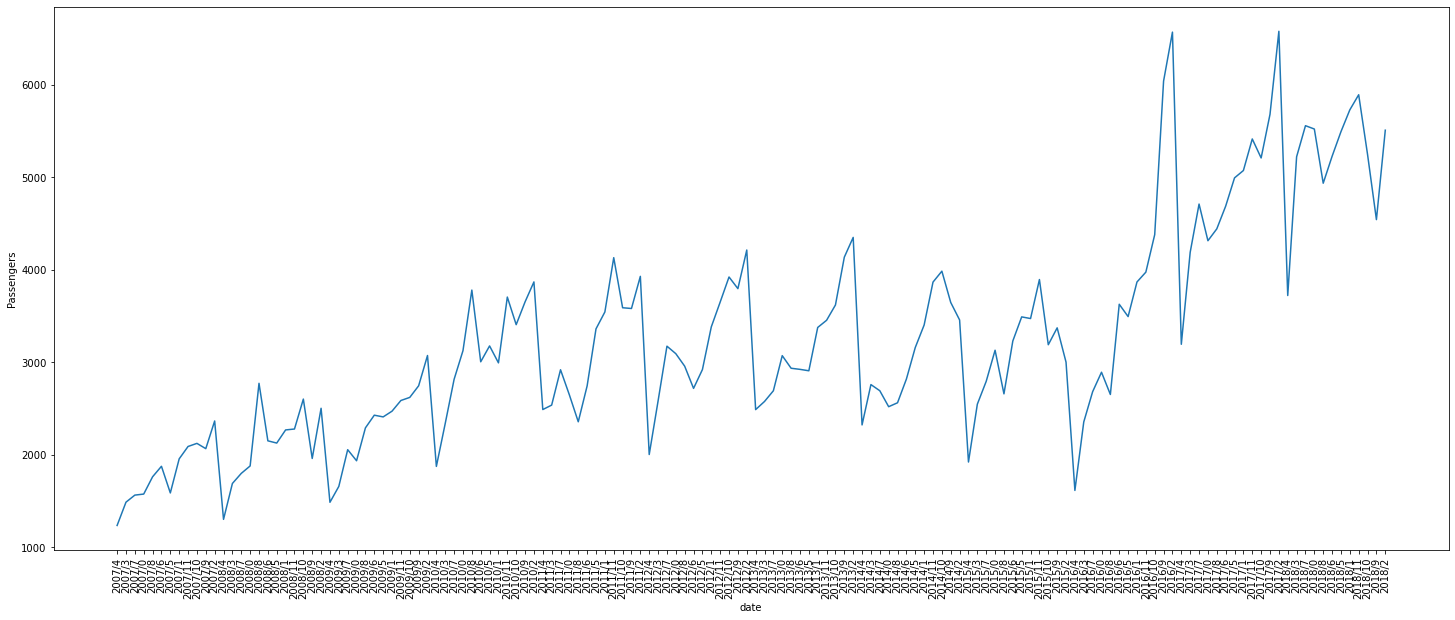

In [32]:
plt.figure(figsize=(25, 10))
sns.lineplot(x='date',y='Passengers',data=train)
plt.xticks(rotation='vertical');

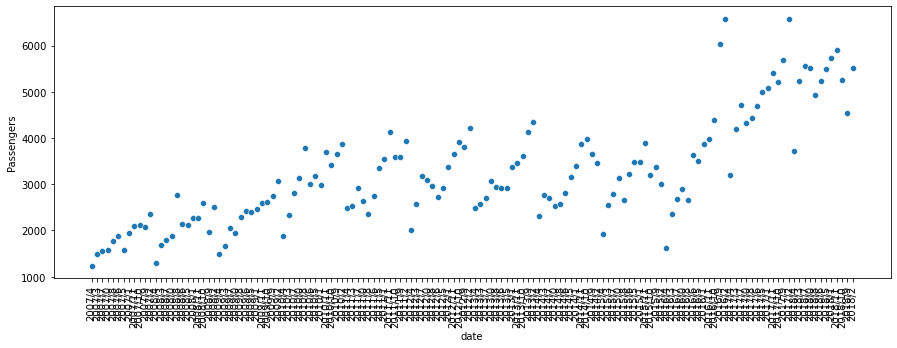

In [31]:
plt.figure(figsize=(15, 5))
sns.scatterplot(x='date',y='Passengers',data=train,)

plt.xticks(rotation='vertical');

In [38]:
print("p-value:", adfuller((train['Passengers']))[1])

p-value: 0.7953456521645764


In [45]:
train['box_cox'] = stats.boxcox(train['Passengers'])[0]

<ipython-input-45-3a3b28177a9e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['box_cox'] = stats.boxcox(train['Passengers'])[0]


In [49]:
print("p-value:", adfuller(((train['box_cox'])))[1])

p-value: 0.6480709677257008


In [50]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

C:\Users\vetak\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Дифференцированный график изменения резерва')

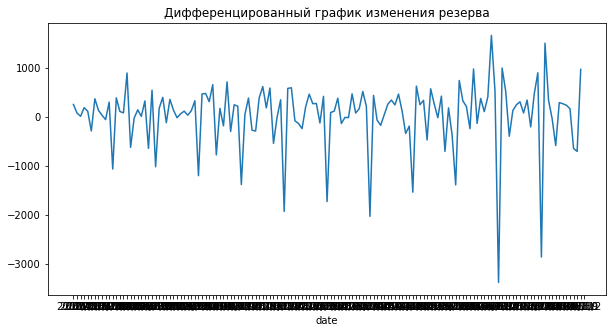

In [52]:
plt.figure(figsize=(10, 5))
sns.lineplot(train['date'], difference(train['Passengers']))
plt.title('Дифференцированный график изменения резерва')

C:\Users\vetak\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Дифференцированный график изменения резерва')

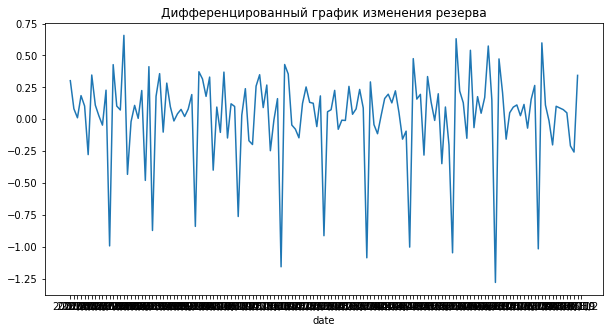

In [53]:
plt.figure(figsize=(10, 5))
sns.lineplot(train['date'], difference(train['box_cox']))
plt.title('Дифференцированный график изменения резерва')

In [89]:
timeseries = train['Passengers']

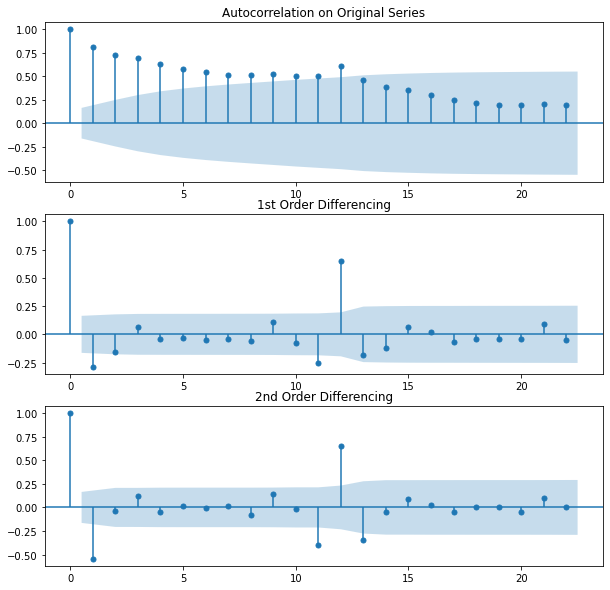

In [90]:

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(311)
fig = plot_acf(timeseries, ax=ax1,
               title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_acf(timeseries.diff().dropna(), ax=ax2, 
               title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(timeseries.diff().diff().dropna(), ax=ax3, 
               title="2nd Order Differencing")

In [91]:
from statsmodels.tsa.arima_model import ARIMA

In [92]:
month = 1
lastday_ = train['box_cox'].iloc[-1] # Последнее истинное значение резерва

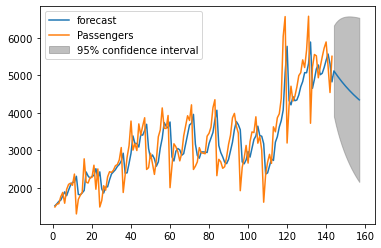

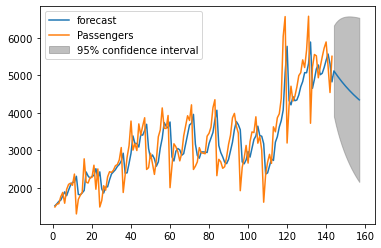

In [93]:

model = ARIMA(timeseries, order=(1, 0, 1))
results = model.fit()
results.plot_predict(1, len(df) + month )


In [112]:
round(results.predict(0,11)).to_list()

[3259.0,
 1519.0,
 1571.0,
 1636.0,
 1670.0,
 1782.0,
 1891.0,
 1788.0,
 1935.0,
 2069.0,
 2146.0,
 2149.0]

In [86]:
def arimamodel(timeseries):
    automodel = pm.auto_arima(timeseries, 
                              start_p=1, 
                              start_q=1,
                              test="adf",
                              seasonal=False,
                              trace=True)
    return automodel

In [87]:
def plotarima(n_periods, timeseries, automodel):
    # Forecast
    fc, confint = automodel.predict(n_periods=n_periods, 
                                    return_conf_int=True)
    # Daily index
    fc_ind = pd.date_range(timeseries.index[timeseries.shape[0]-1], 
                           periods=n_periods, freq="D")
    # Forecast series
    fc_series = pd.Series(fc, index=fc_ind)    # Upper and lower confidence bounds
    lower_series = pd.Series(confint[:, 0], index=fc_ind)
    upper_series = pd.Series(confint[:, 1], index=fc_ind)    # Create plot
    plt.figure(figsize=(20, 6))
    plt.plot(timeseries)
    plt.plot(fc_series, color="red")
    plt.xlabel("date")
    plt.ylabel(timeseries.name)
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color="k", 
                     alpha=0.25)
    plt.legend(("past", "forecast", "95% confidence interval"),  
               loc="upper right")
    plt.show()

In [88]:
automodel = arimamodel((train['Passengers']))
plotarima(90, train['Passengers'], automodel)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2242.768, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2272.119, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2261.921, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2251.951, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2270.402, Time=0.01 sec


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()